In [1]:
import sys
 
# setting path
sys.path.append('..')

import pandas as pd
import mne
import numpy as np
import autoreject
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import sklearn

from mna.sessions.eye_session import process_session_eye
from mna.sessions.eeg_session import process_session_eeg
from mna.sessions.motor_session import process_session_motor
from mna.sessions.ecg_session import process_session_ecg

from mna.utils.batch_feature_extraction import clean_up_adadrive_trials

In [2]:
from os import listdir
from os.path import isfile, join
from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data
import pickle

### Evoked Pupil Diameter (3 sec post trial onset) function

In [3]:
def plot_evoked_pupil_diameter(eyetracking_df, event_df, fs, pupil):
    
    time = np.arange(0, 3, 1/freq)
    trial_onset = event_df['trial_start_time']
    baseline_samples = int(fs*0.2)
    onset_3sec_samples = int(fs*3)
    
    baseline_pupil = np.empty(len(trial_onset.index))
    onset_3sec_pupil = np.empty([len(trial_onset.index),onset_3sec_samples])

    for i in event_df.index:
        
        if (trial_onset[i] == 0) or (trial_onset[i] > max(eyetracking_df.index)): 
            baseline_pupil[i] = float("NaN")
            onset_3sec_pupil[i,:] = float("NaN")
        else:
            trial_baseline_pupil = eyetracking_df[pupil][(eyetracking_df.index >= trial_onset[i]-.2) & 
                                                         (eyetracking_df.index < trial_onset[i])].replace(-1, np.nan)
            
            trial_onset_3sec_pupil = eyetracking_df[pupil][(eyetracking_df.index >= trial_onset[i]) & 
                                                        (eyetracking_df.index < trial_onset[i]+3)].replace(-1, np.nan)
            
            # fill in missing values through interpolation
            trial_baseline_pupil = trial_baseline_pupil.interpolate(method ='linear', limit_direction ='forward')
            trial_onset_3sec_pupil = trial_onset_3sec_pupil.interpolate(method ='linear', limit_direction ='forward')

            # keep all trial dimension consistent through linear interpolation
            if len(trial_baseline_pupil) != baseline_samples:
                baseline_interp = scipy.interpolate.interp1d(np.arange(trial_baseline_pupil.size),trial_baseline_pupil)
                trial_baseline_pupil_interp = baseline_interp(np.linspace(0, trial_baseline_pupil.size-1, baseline_samples))
            else: 
                trial_baseline_pupil_interp = trial_baseline_pupil

            if len(trial_onset_3sec_pupil) != onset_3sec_samples:
                onset_3sec_pupil_interp = scipy.interpolate.interp1d(np.arange(trial_onset_3sec_pupil.size),trial_onset_3sec_pupil)
                trial_onset_3sec_pupil_interp = onset_3sec_pupil_interp(np.linspace(0, trial_onset_3sec_pupil.size-1, onset_3sec_samples))
            else: 
                trial_onset_3sec_pupil_interp = trial_onset_3sec_pupil

            # invalidate trials with more than half invalid samples
            if (np.isnan(trial_baseline_pupil_interp).sum() >= int(baseline_samples*.5) or 
                np.isnan(trial_onset_3sec_pupil_interp).sum() >= int(onset_3sec_samples*.5)):
                baseline_pupil[i] = float("NaN")
            else:
                baseline_pupil[i] = trial_baseline_pupil_interp.mean()
        
            # baseline correction
            onset_3sec_pupil[i,:] = trial_onset_3sec_pupil_interp - baseline_pupil[i]
    
    # evoked pupil diameter
    evoked_pupil_diameter = np.mean(onset_3sec_pupil, axis = 1)
    
    # plot easy and hard trials - averaged
    valid_baseline_trials = onset_3sec_pupil[~np.isnan(baseline_pupil)]
    easy_trials = onset_3sec_pupil[event_df['spoken_difficulty']=='easy']
    hard_trials = onset_3sec_pupil[event_df['spoken_difficulty']=='hard']

    def plot_evoked_trials(trials, line_color, fill_color, trial_label):
        trials_mean = np.nanmean(trials, axis = 0)
        trials_std = np.nanstd(trials, axis = 0)

        under_line = trials_mean - trials_std
        over_line = trials_mean + trials_std

        plt.plot(time, trials_mean, line_color, label = trial_label)
        plt.fill_between(time, under_line, over_line, color=fill_color, alpha=.1)
        plt.legend()

    plot_evoked_trials(easy_trials, 'r-', 'r', 'Easy')
    plot_evoked_trials(hard_trials, 'k-', 'k', 'Hard')
    
    return evoked_pupil_diameter

## Single subject analysis

In [4]:
## 1. Read a RN App, converted pkl file, and create the metadata and data structure
data_dir = "../data/"
lsl_dir = "../mna/LSLPresets/"
output_dir = '../output/'
if not os.path.isdir(output_dir): os.makedirs(output_dir)

onlyfiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.pkl' in f]
input_path = data_dir + onlyfiles[3] # pick a random file
print(f"input_path {input_path}")
metadata_jsons = read_all_lslpresets(path_to_jsonfiles=lsl_dir)

with open(input_path, 'rb') as handle:
    rns_data = pickle.load(handle)

## Add metadata to data

for key in rns_data.keys():
    rns_data[key].append(return_metadata_from_name(key, metadata_jsons))


## 2. Create new events (trial start etc.)

event_df = event_data_from_data(rns_data)
event_df['trial_damage'] = event_df.damage.diff().fillna(0)
event_df['trial_duration'] = event_df.trial_end_time - event_df.trial_start_time
percent_missing = event_df.notnull().sum() / len(event_df)
summary_statistics = {}
summary_statistics['voice_success_rate'] = percent_missing['voice_timestamp']
if 'chunk_timestamp' in percent_missing:
    summary_statistics['chunk_success_rate'] = percent_missing['chunk_timestamp']
else:
    summary_statistics['chunk_success_rate'] = 0

# temporary fix for pilot phase where we had some incomplete data
if 'block_condition' not in event_df:
    event_df['block_condition'] = 'practice'
    event_df.loc[5:,'block_condition'] = 'voice'

event_df['spoken_difficulty_encoded'] = event_df.spoken_difficulty.replace(to_replace=['easy', 'hard', 'unknown'],
                                                                      value=[1, 2, None])

## create dataframe
eye_channel='Unity_ViveSREyeTracking'
df_eye = pd.DataFrame(rns_data[eye_channel][0], columns=rns_data[eye_channel][1],
                      index=rns_data[eye_channel][2]['ChannelNames']).T

# df_eye = df_eye.reset_index().rename(columns={'index':'timestamp'})

freq = rns_data[eye_channel][2]['NominalSamplingRate']



input_path ../data/08_25_2022_10_32_35-Exp_adadrive-Sbj_12-Ssn_01.dats.pkl


In [5]:
processed_eye_events = process_session_eye(rns_data, event_df)

Computed velocity exceeds threshold. Inappropriate filter setup? [3886.6 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2525.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2478.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1889.9 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [3640.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2384.0 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2893.7 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1132.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1536.8 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [2498.4 > 1000.0 deg/s]
Computed velocity exceeds threshold. Inappropriate filter setup? [1794.0 > 1000.0 deg/s]
Computed velocity exc

In [6]:
processed_eye_events

,trial_start_time,trial_end_time,ppid,session,block,number_in_block,trial,density,damage,source,...,REMODNAV_mean_duration.Saccade,REMODNAV_mean_duration.Smooth Pursuit,REMODNAV_count,REMODNAV_first_onset,REMODNAV_mean_duration,REMODNAV_class_onsets,Left Pupil Diameter,Right Pupil Diameter,Left Evoked Pupil Diameter,Right Evoked Pupil Diameter
0,0.000000,3908.097072,12.0,1.0,1.0,1.0,1.0,0.000000,0.000000,4.0,...,0.049978,0.320939,NaN,NaN,NaN,"[[3849.906949821412, Fixation], [3849.94858608...",2.480001,2.932532,NaN,NaN
1,3908.107072,3920.486814,12.0,1.0,1.0,2.0,2.0,0.100000,0.000000,4.0,...,0.042872,0.479775,NaN,NaN,NaN,"[[3908.1131594294, Fixation], [3908.1881412233...",2.754170,3.176125,-0.516196,-0.509417
2,3920.496814,3933.183491,12.0,1.0,1.0,3.0,3.0,0.300000,16.203644,4.0,...,0.043157,0.319385,NaN,NaN,NaN,"[[3920.498024696407, Smooth Pursuit], [3920.68...",2.255300,2.565652,-0.641328,-0.814819
3,3933.193491,3943.065886,12.0,1.0,1.0,4.0,4.0,0.500000,26.125107,4.0,...,0.041310,0.381526,NaN,NaN,NaN,"[[3933.195624126918, Fixation], [3933.38733201...",2.107097,2.386616,-0.186731,-0.258607
4,3943.075886,3986.279977,12.0,1.0,1.0,5.0,5.0,0.700000,34.027912,4.0,...,0.053107,0.292654,NaN,NaN,NaN,"[[3943.080148025521, Smooth Pursuit], [3943.52...",2.210286,2.601601,0.124909,0.187253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,5183.761111,5208.108798,12.0,1.0,11.0,4.0,75.0,0.148238,746.601440,0.0,...,0.047759,0.360767,NaN,NaN,NaN,"[[5183.770071967823, Fixation], [5183.82936717...",2.188651,2.511068,0.104543,0.187656
64,5208.118798,5231.376608,12.0,1.0,11.0,5.0,76.0,0.295827,746.601440,0.0,...,NaN,NaN,NaN,NaN,NaN,"[[5208.125448507131, nan], [5208.654610640411,...",2.215525,2.573583,0.137968,0.116741
65,5231.386608,5254.097690,12.0,1.0,11.0,6.0,77.0,0.769361,746.601440,0.0,...,0.063760,0.356450,NaN,NaN,NaN,"[[5231.394852697417, Fixation], [5231.46629682...",2.432625,2.815211,0.253194,0.337262
66,5254.107690,5276.063566,12.0,1.0,11.0,7.0,78.0,0.578679,746.601440,0.0,...,0.618189,0.404123,NaN,NaN,NaN,"[[5254.1109468674495, Saccade], [5266.76934040...",2.229693,2.564801,0.180914,0.188116


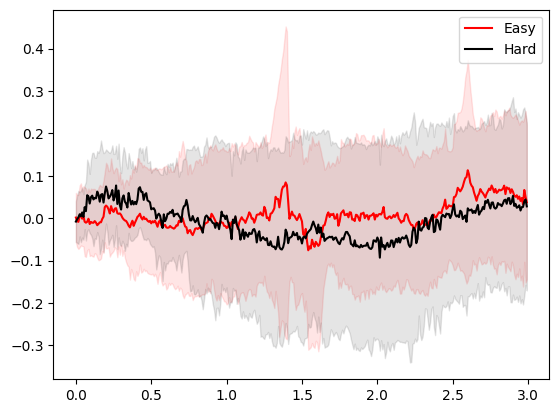

In [9]:
# evoked_pupil_diameter_L, post_cue_3sec_L, baseline_pupil = plot_evoked_pupil_diameter(df_eye, event_df, 
#                                                                             freq, 'L Pupil Diameter')

# # df_eye.to_csv('df_test.csv')

## Batch Analysis

In [10]:
data_dir = "../data/"
lsl_dir = "../mna/LSLPresets/"
output_dir = '../output/'
if not os.path.isdir(output_dir): os.makedirs(output_dir)

onlyfiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.pkl' in f]
metadata_jsons = read_all_lslpresets(path_to_jsonfiles=lsl_dir)

for each_file in onlyfiles:
    input_path = data_dir + each_file
    
    sbj_id = each_file[each_file.find('Sbj_')+4:each_file.find('-Ssn')]
    ssn_no = each_file[each_file.find('Ssn_')+4:each_file.find('.dats')]
    
    if len(sbj_id) < 2: sbj = "sbj0"+sbj_id
    else: sbj = "sbj"+sbj_id
    if len(ssn_no) < 2: ssn = "ssn0"+ssn_no
    else: ssn = "ssn"+ssn_no
    
    with open(input_path, 'rb') as handle:
        rns_data = pickle.load(handle)

    ## Add metadata to data

    for key in rns_data.keys():
        rns_data[key].append(return_metadata_from_name(key, metadata_jsons))

    event_df = event_data_from_data(rns_data)
    event_df['trial_damage'] = event_df.damage.diff().fillna(0)
    event_df['trial_duration'] = event_df.trial_end_time - event_df.trial_start_time
    percent_missing = event_df.notnull().sum() / len(event_df)
    summary_statistics = {}
    summary_statistics['voice_success_rate'] = percent_missing['voice_timestamp']
    if 'chunk_timestamp' in percent_missing:
        summary_statistics['chunk_success_rate'] = percent_missing['chunk_timestamp']
    else:
        summary_statistics['chunk_success_rate'] = 0
        
    eye_channel='Unity_ViveSREyeTracking'
    df_eye = pd.DataFrame(rns_data[eye_channel][0], columns=rns_data[eye_channel][1],
                          index=rns_data[eye_channel][2]['ChannelNames']).T

    freq = rns_data[eye_channel][2]['NominalSamplingRate']

    evoked_pupil_diameter_L, post_cue_3sec_L, baseline_pupil = plot_evoked_pupil_diameter(df_eye, event_df, 
                                                                            freq, 'L Pupil Diameter')
    
    plt.savefig(f"{output_dir+'plots/'+'Left_Evoked_Pupil_Plots/'}{sbj+ssn}.png")
    plt.close()

# Classification

## Pupil Diameter Extraction

In [ ]:
eye_channel='Unity_ViveSREyeTracking'
df_eye = pd.DataFrame(rns_data[eye_channel][0], columns=rns_data[eye_channel][1],
                      index=rns_data[eye_channel][2]['ChannelNames']).T

n_samples = rns_data[eye_channel][2]['NominalSamplingRate']*6

label = np.empty(len(event_df.index)-1)
trials_left_pupil = np.empty([len(event_df.index)-1, n_samples])
trials_right_pupil = np.empty([len(event_df.index)-1, n_samples])

#Skip last trial because it's empty
for i in range(len(event_df.index)-1):
    L_Pupil_Diameter = np.asarray(df_eye['L Pupil Diameter'][(df_eye.index >= event_df['trial_start_time'][i]) &
                                         (df_eye.index <= event_df['trial_end_time'][i]) &
                                                   (df_eye['L Pupil Diameter'] > -1)].replace(-1, np.nan))
    trials_left_pupil[i, :] = L_Pupil_Diameter[:n_samples]

    R_Pupil_Diameter = np.asarray(df_eye['R Pupil Diameter'][(df_eye.index >= event_df['trial_start_time'][i]) &
                                         (df_eye.index <= event_df['trial_end_time'][i]) &
                                                   (df_eye['R Pupil Diameter'] > -1)].replace(-1, np.nan))
    trials_right_pupil[i, :] = R_Pupil_Diameter[:n_samples]

    label[i] = event_df.spoken_difficulty_encoded[i]

trials_left_pupil = trials_left_pupil[pd.isna(label)==False]
trials_right_pupil = trials_right_pupil[pd.isna(label)==False]
label = label[pd.isna(label)==False].astype(int)

## Artifact Removal

In [ ]:
eeg_montage = 'biosemi64'
eeg_channel = 'BioSemi'
run_autoreject=True
autoreject_epochs=20
average_reference=True
downsampling = True
n_decim = 16
low_cut=1.
hi_cut=50.

event_column='spoken_difficulty_encoded'

event_detected = event_df[event_column].notnull()
event_recognized_df = event_df[event_detected]

eeg_channel_names = mne.channels.make_standard_montage(eeg_montage).ch_names
df = pd.DataFrame(rns_data[eeg_channel][0], columns=rns_data[eeg_channel][1],
                  index=rns_data[eeg_channel][2]['ChannelNames']).T
starting_time_s = rns_data[eeg_channel][1][0]
freq = rns_data[eeg_channel][2]['NominalSamplingRate']
rna_channel_names = list(df.columns)
rna_channel_names[1:65] = eeg_channel_names
info = mne.create_info(ch_names=rna_channel_names, ch_types=['stim'] + ['eeg'] * 64 + ['ecg'] * 2 + ['misc'] * 22,
                       sfreq=freq)
info.set_montage(eeg_montage)

raw = mne.io.RawArray(df.T * 1e-6, info)
raw = raw.pick(['eeg'])
if average_reference:
    raw = raw.set_eeg_reference(ref_channels='average')  # set average reference
if low_cut or hi_cut:
    raw.filter(l_freq=low_cut, h_freq=hi_cut, verbose=False)
if downsampling:
    raw.resample(freq/n_decim)

freq /= n_decim
    
trial_start_time = event_recognized_df.trial_start_time - starting_time_s  # reference for mne
event_values = event_recognized_df[event_column].values
events = np.column_stack((trial_start_time.values * freq,
                          np.zeros(len(event_recognized_df), dtype=int),
                          event_values)).astype(int)
event_dict = dict(easy=1, hard=2)
epochs = mne.Epochs(raw, events, event_id=event_dict, baseline = (None, None), tmin=-3, tmax=0, preload=True, on_missing='warn')

event_recognized_df = event_recognized_df[[e==() for e in epochs.drop_log]] # only keep good epochs in event_df


In [ ]:
#Autoreject
if len(epochs) < 10: # we need at least 10 epochs to run autoreject for cross validation
    bad_epochs = pd.Series(np.full(len(event_df),np.NAN), index=event_df.index, name='autorejected')
    event_df = event_df.join(bad_epochs)
    reject_log = None

elif run_autoreject:
    ar = autoreject.AutoReject(random_state=11, n_jobs=2, verbose=False)
    ar.fit(epochs[:autoreject_epochs])  # fit on a few epochs to save time
    epochs_ar, reject_log = ar.transform(epochs, return_log=True)
    bad_epochs = pd.Series(reject_log.bad_epochs, index=event_recognized_df.index, dtype=bool, name='autorejected')
    event_df = event_df.join(bad_epochs) # creates nan if not processed at all
    epochs = epochs_ar

In [ ]:
# epochs.drop_log
# event_df
raw.plot()

In [ ]:
ica = mne.preprocessing.ICA(n_components=64, random_state=64)
ica.fit(raw)

In [ ]:
# ica.plot_sources(epochs[:10], picks=[0,1,2,3,4,5])
ica.plot_components()

In [ ]:
ica.plot_sources(epochs[:10], picks=[0,1,2,3,4,5])

In [ ]:
# Artifact Detection
eog_idx, eog_scores = ica.find_bads_eog(raw, ch_name = ['Fp1', 'Fp2'])
# ecg_idx, ecg_scores = ica.find_bads_ecg(raw, method='ctps', measure='correlation', threshold="auto")
# muscle_idx, muscle_scores = ica.find_bads_muscle(raw)

# print([eog_idx, ecg_idx, muscle_idx])
print([eog_idx])

# ica.plot_scores(eog_scores, exclude=eog_idx)
# ica.plot_scores(ecg_scores, exclude=ecg_idx)
# ica.plot_scores(muscle_scores, exclude=muscle_idx)

# first half all non-ECG component (EOG component was identified as ECG component as well). second half eog component
# non_ECG_comp = list(set(np.arange(ica.n_components_)).symmetric_difference(set(ecg_idx))) + \
#                list(set(ecg_idx).intersection(set(eog_idx)))

In [ ]:
# Identified Artifact Component Removal
eeg_data_ICA = raw.copy()
# ica.apply(eeg_data_ICA, exclude=eog_idx+ecg_idx+muscle_idx)
# ica.apply(eeg_data_ICA, exclude=eog_idx+ecg_idx)
ica.apply(eeg_data_ICA, exclude=eog_idx)
# ica.apply(eeg_data_ICA, exclude=non_ECG_comp)

eeg_data_ICA_epochs = mne.Epochs(eeg_data_ICA, events, event_id=event_dict, baseline = (None, None), tmin=-3, tmax=0, preload=True, on_missing='warn')

del eeg_data_ICA

In [ ]:
# plot before and after component removal signal
# epochs.plot(n_channels=10, n_epochs=5, show_scrollbars=False)
# eeg_data_ICA.plot(n_channels=10, n_epochs=5, show_scrollbars=False)

## Trial Difficulty Classification

In [ ]:
from sklearn.model_selection import train_test_split
from mne_features.univariate import compute_hjorth_mobility,compute_pow_freq_bands

# Dataset Split - EEG
x_train_raw, x_test_raw, y_train_raw, y_test_raw = train_test_split(epochs.get_data()[:,:64,:], epochs.events[:,2], random_state=64, test_size=10)
x_train_AR, x_test_AR, y_train_AR, y_test_AR = train_test_split(eeg_data_ICA_epochs.get_data()[:,:64,:], eeg_data_ICA_epochs.events[:,2],
                                                                    random_state=64, test_size=10)

# Dataset Split - Pupil Diameter
x_train_pupil, x_test_pupil, y_train_pupil, y_test_pupil = train_test_split(trials_left_pupil, label, random_state=64, test_size=10)

# Feature extraction
def eeg_feature(train_raw, test_raw, train_ar, test_ar, method, band_intervals = None):

    if method == 'psd':

        band_freq = band_intervals

        train_feature_raw = np.empty([len(train_raw), len(eeg_channel_names)*(len(band_freq)-1)])
        test_feature_raw = np.empty([len(test_raw), len(eeg_channel_names)*(len(band_freq)-1)])
        train_feature_ar = np.empty([len(train_ar), len(eeg_channel_names)*(len(band_freq)-1)])
        test_feature_ar = np.empty([len(test_ar), len(eeg_channel_names)*(len(band_freq)-1)])

        for i in range(len(train_raw)):

            train_feature_raw[i,:] = compute_pow_freq_bands(freq, train_raw[i], freq_bands = band_freq)
            train_feature_ar[i,:] = compute_pow_freq_bands(freq, train_ar[i], freq_bands = band_freq)

        for j in range(len(test_raw)):
            test_feature_raw[j,:] = compute_pow_freq_bands(freq, test_raw[j], freq_bands = band_freq)
            test_feature_ar[j,:] = compute_pow_freq_bands(freq, test_ar[j], freq_bands = band_freq)

    if method == 'hjorth_mobility':
        train_feature_raw = compute_hjorth_mobility(train_raw)
        test_feature_raw = compute_hjorth_mobility(test_raw)

        train_feature_ar = compute_hjorth_mobility(train_ar)
        test_feature_ar = compute_hjorth_mobility(test_ar)

    if method == "temporal_avg":
        train_feature_raw = np.mean(x_train_AR, axis = -1)
        test_feature_raw = np.mean(x_test_AR, axis = -1)

        train_feature_ar = np.mean(x_train_raw, axis = -1)
        test_feature_ar = np.mean(x_test_raw, axis = -1)

    return train_feature_raw, test_feature_raw, train_feature_ar, test_feature_ar

# call function for eeg feature extraction
raw_train_feature, raw_test_feature, AR_train_feature, AR_test_feature = eeg_feature(x_train_raw, x_test_raw, 
                                                                                     x_train_AR, x_test_AR, 
                                                                                     'psd', band_intervals = np.array([3,8,13,30,64]))

In [ ]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns

# Trial Difficulty Classification Function
def spoken_difficulty_classification(train_data, test_data, train_label, test_label, method):

    if method == 'logistic':

        logreg = LogisticRegression(solver="liblinear", random_state=0).fit(train_data, train_label)
        score_train = logreg.decision_function(train_data)
        score_test = logreg.decision_function(test_data)

        train_pred = logreg.predict(train_data)
        test_pred = logreg.predict(test_data)

    if method == 'svm':

        svm_classifer = SGDClassifier(random_state=0).fit(train_data, train_label)
        score_train = svm_classifer.decision_function(train_data)
        score_test = svm_classifer.decision_function(test_data)

        train_pred = svm_classifer.predict(train_data)
        test_pred = svm_classifer.predict(test_data)

    if method == 'knn':
        kNN = KNeighborsClassifier(n_neighbors = 3).fit(train_data, train_label)

        score_train = kNN.predict_proba(train_data)[:,1]
        score_test = kNN.predict_proba(test_data)[:,1]

        train_pred = (score_train > 0.5) + 0
        test_pred = (score_test >0.5) + 0

    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(train_label-1, score_train)
    ROC_score_train = metrics.roc_auc_score (train_label-1, score_train)

    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(test_label-1, score_test)
    ROC_score_test = metrics.roc_auc_score (test_label-1, score_test)

    train_acc = metrics.accuracy_score(train_label,train_pred)
    test_acc = metrics.accuracy_score(test_label,test_pred)

    # ROC Curve
    fig = plt.figure(figsize = [10 ,3])

    axe = fig.add_subplot(1,2,1)
    axe.plot(fpr_train,tpr_train)
    axe.set_xlabel("False Positive Rate")
    axe.set_ylabel("True Positive Rate")
    axe.set_title("Training ROC Curve")
    axe.text(0.6,0.2,"ROC Score = {:.2f}".format(ROC_score_train))

    axe = fig.add_subplot(1,2,2)
    axe.plot(fpr_test,tpr_test)
    axe.set_xlabel("False Positive Rate")
    axe.set_ylabel("True Positive Rate")
    axe.set_title("Testing ROC Curve")
    axe.text(0.6,0.2,"ROC Score = {:.2f}".format(ROC_score_test))

    # plt.grid(visible=False)
    # Confusion Matrix
    # fig, (ax1, ax2) = plt.subplots(1,2)
    fig_cnf = plt.figure(figsize = [10 ,3])
    ax1 = fig_cnf.add_subplot(1,2,1)
    ax2 = fig_cnf.add_subplot(1,2,2)

    cnf_matrix_train = metrics.confusion_matrix(train_label, train_pred)
    cnf_matrix_test = metrics.confusion_matrix(test_label, test_pred)

    sns.heatmap(cnf_matrix_train, annot = True, xticklabels = ['Easy','Hard'], yticklabels = ['Easy','Hard'],ax=ax1)
    ax1.set_title("Training Confusion Matrix")
    sns.heatmap(cnf_matrix_test, annot = True, xticklabels = ['Easy','Hard'], yticklabels = ['Easy','Hard'],ax=ax2)
    ax2.set_title("Testing Confusion Matrix")
    plt.show()

    return test_pred, train_pred, train_acc, test_acc

In [ ]:
# Trial Difficulty Classification - Pupil Diameter
test_pred_raw, train_pred_raw, train_acc_raw, test_acc_raw = spoken_difficulty_classification(x_train_pupil, x_test_pupil,y_train_pupil, y_test_pupil, 'logistic')

# print(f"Training Accuracy with Pupil Diameter: {train_acc_raw:.2f} \n"
#       f"Train Label:      {y_train_raw} \n"
#       f"Train Prediction: {train_pred_raw} \n"
#       f"Test Accuracy with Pupil Diameter: {test_acc_raw:.2f} \n"
#       f"Test Label:      {y_test_raw} \n"
#       f"Test Prediction: {test_pred_raw}\n")

In [ ]:
# Trial Difficulty Classification - Raw EEG
test_pred_raw, train_pred_raw, train_acc_raw, test_acc_raw = spoken_difficulty_classification(raw_train_feature, raw_test_feature,y_train_raw, y_test_raw, 'logistic')

# print(f"Training Accuracy without Artifacts Removal: {train_acc_raw:.2f} \n"
#       f"Train Label:      {y_train_raw} \n"
#       f"Train Prediction: {train_pred_raw} \n"
#       f"Test Accuracy without Artifacts Removal: {test_acc_raw:.2f} \n"
#       f"Test Label:      {y_test_raw} \n"
#       f"Test Prediction: {test_pred_raw}\n")

In [ ]:
# Trial Difficulty Classification - Artifacts Removed EEG

test_pred_AR, train_pred_AR, train_acc_AR, test_acc_AR = spoken_difficulty_classification(AR_train_feature, AR_test_feature,y_train_AR, y_test_AR, 'logistic')

# print(f"Training Accuracy with Artifacts Removal: {train_acc_AR:.2f} \n"
#       f"Training Label:      {y_train_AR} \n"
#       f"Training Prediction: {train_pred_AR} \n"
#       f"Test Accuracy with Artifacts Removal: {test_acc_AR:.2f} \n"
#       f"Test Label:      {y_test_AR} \n"
#       f"Test Prediction: {test_pred_AR}")

## ICA-Adaptive Filter - WIP

In [ ]:
# ! pip install EMD-signal

In [ ]:
# !pip install EMD-signal
# # import PyEMD
# from PyEMD import EMD, Visualisation

# eeg_comps = ica.get_sources(raw).get_data() #eeg componenets for all epochs
# # eeg_comps = ica.get_sources(epochs).get_data() #eeg componenets for all epochs
# # comps_epoch_concat = np.empty([eeg_comps.shape[1],eeg_comps.shape[2]*eeg_comps.shape[0]]) #initiate empty array
# # for i in range(eeg_comps.shape[0]):
# #     comps_epoch_concat[:,i*eeg_comps.shape[2]:eeg_comps.shape[2]*(i+1)] = eeg_comps[i]

# component_no = 5
# test_comps = eeg_comps[component_no]

# emd = EMD() # EMD instantiation
# emd.emd(test_comps) # decompose signal into IMFs and residue
# imfs, res = emd.get_imfs_and_residue()

# # # imfs = emd(np.squeeze(eeg_comps[0])[0])

In [ ]:
# scipy.stats.kurtosis(test_comps)

In [ ]:
# # Visualization
# t = np.arange(0, 3+1/freq, 1/freq)
# vis = Visualisation()
# vis.plot_imfs(imfs=imfs, residue=res, t=t, include_residue=True)
# # vis.plot_instant_freq(t, imfs=imfs)
# vis.show()